# Feature Engineering Project: Predict Wine Quality with Regularization



The data is from the Wine Quality Dataset in the UCI Machine Learning Repository. I am looking at the red wine data in particular and while the original dataset has a 1-10 rating for each wine, I’ve made it a classification problem with a wine quality of good (>5 rating) or bad (<=5 rating). The goals of this project is to model wine quality based on physicochemical tests. In order to get there I will perform task including:


* implement different logistic regression classifiers
* find the best ridge-regularized classifier using hyperparameter tuning
* implement a tuned lasso-regularized feature selection method




Let's explore these options by looking at the data we have available to us. First let's answer few questions:

* What the total number of records in the dataset?
* What are the columns, or features, of the dataset?
* What is the test result of the first wine in the dataset?

In [408]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv('wine_quality.csv', delimiter=';')
print(data.columns)
print(data.info())
print(f'There are {data.shape[0]}, records and {data.shape[1]} features')
print(f'Taste of the first wine in data set in 1-10 scale: ', data.iloc[0,-1])




Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11 

Lets transform `quality` scores into `1` (good, score above 5) and `0` (bad, score 5 or bellow). To transform columns values, I will use `list comprehension`

In [409]:
data['quality'] = [1 if number > 5 else 0 for number in data['quality']]

Now, let's split our data

In [410]:
y = data['quality']
features = data.drop(columns = ['quality'])


Before we begin modeling, let’s scale our data using `StandardScaler()`

In [411]:
from sklearn.preprocessing import StandardScaler
standard_scaler_fit = StandardScaler().fit(features)
X = standard_scaler_fit.transform(features)

Perform an 80:20 train-test split on the data. Set the random_state to 7 for reproducibility.

In [412]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Fit a logistic regression classifier without regularization

Define a classifier, `clf_no_reg`, a logistic regression model without regularization and fit it to the training data.

In [413]:
from sklearn.linear_model import LogisticRegression

clf_no_reg = LogisticRegression(penalty='none')
clf_no_reg.fit(x_train, y_train)

LogisticRegression(penalty='none')

I am going to plot the `coefficients` obtained from fitting the Logistic Regression model.

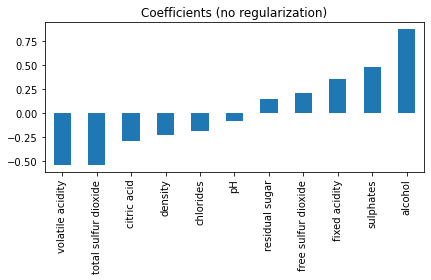

[-0.54416535 -0.53811713 -0.29307633 -0.22656403 -0.18861022 -0.08429932
  0.1444805   0.2139364   0.35613203  0.48679861  0.87730942]


<Figure size 432x288 with 0 Axes>

In [414]:
predictors = features.columns
coefficients = clf_no_reg.coef_.ravel()
coef = pd.Series(coefficients, predictors).sort_values()
coef.plot(kind='bar', title = 'Coefficients (no regularization)')
plt.tight_layout()
plt.savefig('Coefficients (no regularization.jpg')
plt.show()
plt.clf()
print(np.sort(coefficients))

Now I am ready to evaluate this classifier. In the case of linear regression, we evaluated our models using mean-squared-error. For classifiers, it is important that the classifier not only has high accuracy, but also high precision and recall, i.e., a low false positive and false negative rate.

A metric known as `f1 score`, which is the weighted mean of `precision` and `recall`, captures the performance of a classifier holistically. It takes values between 0 and 1 and the closer it is to 1, the better the classifier. Use f1_score() to calculate the f1 score for the training and test data.

In [415]:
from sklearn.metrics import f1_score
y_pred_test = clf_no_reg.predict(x_test)
y_pred_train = clf_no_reg.predict(x_train)
print('Training Score f1:', f1_score(y_train, y_pred_train))
print('Testing Score f1:', f1_score(y_test, y_pred_test))

Training Score f1: 0.7500000000000001
Testing Score f1: 0.7934782608695652


# Default Implementation (L2-regularized)

In [416]:

clf_default = LogisticRegression()
clf_default.fit(x_train, y_train)

LogisticRegression()

Obtain the training and test `f1_score` for the ridge-regularized classifier

In [417]:
y2_pred_train = clf_default.predict(x_train)
y2_pred_test = clf_default.predict(x_test)
print('Ridge regularized Training Score', f1_score(y_train, y2_pred_train))
print('Ridge regularized Testing Score', f1_score(y_test, y2_pred_test))

Ridge regularized Training Score 0.7500000000000001
Ridge regularized Testing Score 0.7934782608695652


The `scores` remain the same! Does this mean that regularization did nothing? Indeed! This means that the constraint boundary for the regularization we performed is large enough to hold the original loss function minimum, thus rendering our model the same as the unregularized one.

How can we tune up the regularization? Recall that C is the inverse of the `regularization strength` (alpha), meaning that smaller values of `C` correspond to more regularization. The scikit-learn default for `C` is 1; therefore, in order to increase the amount of regularization, we need to consider values of `C` that are less than 1. But how far do we need to go? Let’s try a `coarse-grained search` before performing a `fine-grained` one.

In [418]:
training_array = []
test_array = []
C_array = [0.0001, 0.001, 0.01, 0.1, 1]

for x in C_array:
  clf = LogisticRegression(C = x)
  clf.fit(x_train, y_train)
  y_predicted_train = clf.predict(x_train)
  y_predicted_test = clf.predict(x_test)
  training_array.append(f1_score(y_train, y_predicted_train))
  test_array.append(f1_score(y_test, y_predicted_test))

Let's plot the training and test scores as a function of C. Does this clarify the range of C’s we need to be doing a fine-grained search for? Ofcourse! `The optimal C` seems to be somewhere around `0.001` so a search window between `0.0001 and 0.01` is not a bad idea here!

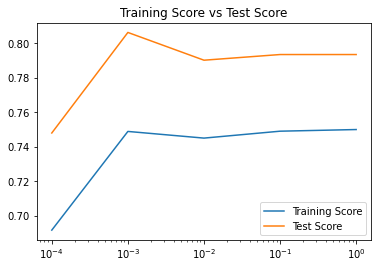

Max f1 test score 0.8062827225130889
Argument for best f1 test score 0.001


<Figure size 432x288 with 0 Axes>

In [419]:
plt.plot(C_array, training_array, label='Training Score')
plt.plot(C_array, test_array, label='Test Score')
plt.xscale('log')
plt.legend()
plt.title('Training Score vs Test Score')
plt.savefig('Training Score vs Test Score.jpg')
plt.show()
plt.clf()

print('Max f1 test score', np.max(test_array))
print('Argument for best f1 test score', C_array[np.argmax(test_array)])

# Hyperparameter Tuning for L2 Regularization

Now I am ready to perform hyperparameter tuning using `GridSearchCV`. Looking at the plot, the optimal C seems to be somewhere around 0.001 so a search window between 0.0001 and 0.01 will be my target.

Let’s first get setup with the right inputs for this. Use `np.logspace()` to obtain 100 values between `10^(-4) and 10^(-2)` and define a dictionary of C values named `tuning_C` that can function as an input to `GridSearchCV‘s` parameter grid.

In [420]:
C_array = np.logspace(-4, -2, num=100)
tuning_C = {'C':C_array}

Define a grid search model on the parameter grid defined above for a logistic regression model with ridge regularization.

In [421]:
from sklearn.model_selection import GridSearchCV
clf_gs = LogisticRegression()
gs = GridSearchCV(clf_gs, param_grid = tuning_C, scoring='f1', cv=5)
gs.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.0001    , 0.00010476, 0.00010975, 0.00011498, 0.00012045,
       0.00012619, 0.00013219, 0.00013849, 0.00014508, 0.00015199,
       0.00015923, 0.00016681, 0.00017475, 0.00018307, 0.00019179,
       0.00020092, 0.00021049, 0.00022051, 0.00023101, 0.00024201,
       0.00025354, 0.00026561, 0.00027826, 0.00029151, 0.00030539,
       0.00031...
       0.00205651, 0.00215443, 0.00225702, 0.00236449, 0.00247708,
       0.00259502, 0.00271859, 0.00284804, 0.00298365, 0.00312572,
       0.00327455, 0.00343047, 0.00359381, 0.00376494, 0.00394421,
       0.00413201, 0.00432876, 0.00453488, 0.00475081, 0.00497702,
       0.00521401, 0.00546228, 0.00572237, 0.00599484, 0.00628029,
       0.00657933, 0.00689261, 0.00722081, 0.00756463, 0.00792483,
       0.00830218, 0.00869749, 0.00911163, 0.00954548, 0.01      ])},
             scoring='f1')

Obtain the `best C value` from this search and the score corresponding to it using the `best_params_` and `best_score` attributes

In [422]:
print(gs.best_params_, gs.best_score_)

{'C': 0.0003853528593710527} 0.7543316521850431


The above reflects the `mean f1-score` on the 5 folds corresponding to the best classifier. Notice however that I haven’t yet used the test data, `X_test`, `y_test` from our original train-test split. This was done with good reason: the original test data can now be used as our `validation dataset` to validate whether our `best classifier` is doing as well as we’d like it to on essentially unknown data.

In [423]:
clf_best_ridge = LogisticRegression(C=gs.best_params_['C'])
clf_best_ridge.fit(x_train, y_train)
y_pred_best = clf_best_ridge.predict(x_test)
print('Best f1 score', f1_score(y_test, y_pred_best))

Best f1 score 0.8048192771084337


Now I am going to use a grid search cross-validation method to regularize the classifier, but with `L1 regularization` instead. Instead of using `GridSearchCV`, I am going to use `LogisticRegressionCV`.

In [424]:
from sklearn.linear_model import LogisticRegressionCV
C_array = np.logspace(-2, 2, 100)
clf_l1 = LogisticRegressionCV(Cs=C_array, cv=5, penalty='l1', scoring='f1', solver='liblinear')
clf_l1.fit(X, y)

LogisticRegressionCV(Cs=array([1.00000000e-02, 1.09749877e-02, 1.20450354e-02, 1.32194115e-02,
       1.45082878e-02, 1.59228279e-02, 1.74752840e-02, 1.91791026e-02,
       2.10490414e-02, 2.31012970e-02, 2.53536449e-02, 2.78255940e-02,
       3.05385551e-02, 3.35160265e-02, 3.67837977e-02, 4.03701726e-02,
       4.43062146e-02, 4.86260158e-02, 5.33669923e-02, 5.85702082e-02,
       6.42807312e-02, 7.05...
       1.70735265e+01, 1.87381742e+01, 2.05651231e+01, 2.25701972e+01,
       2.47707636e+01, 2.71858824e+01, 2.98364724e+01, 3.27454916e+01,
       3.59381366e+01, 3.94420606e+01, 4.32876128e+01, 4.75081016e+01,
       5.21400829e+01, 5.72236766e+01, 6.28029144e+01, 6.89261210e+01,
       7.56463328e+01, 8.30217568e+01, 9.11162756e+01, 1.00000000e+02]),
                     cv=5, penalty='l1', scoring='f1', solver='liblinear')

The classifier has the attribute `C_` which prints the optimal `C value`. The attribute `coef_` gives us the coefficients of the `best lasso-regularized classifier`. Print both of these.

In [425]:
print('Best C value', clf_l1.C_)
print('Best fit coefficients', clf_l1.coef_)

Best C value [0.25950242]
Best fit coefficients [[ 0.11652613 -0.55641114 -0.17271836  0.03124401 -0.17328378  0.20053783
  -0.50584525  0.         -0.07040858  0.43225549  0.94103594]]


I can now reproduce the `coefficient plot` I'd produced for the `unregularized` scenario.

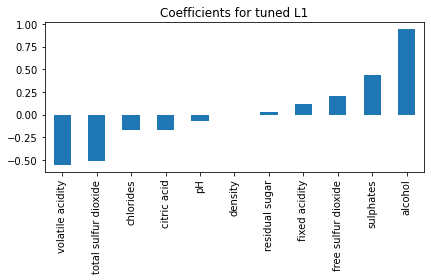

<Figure size 432x288 with 0 Axes>

In [426]:
coefficients = clf_l1.coef_.ravel()
coef = pd.Series(coefficients, predictors).sort_values()

coef.plot(kind='bar', title='Coefficients for tuned L1')
plt.tight_layout()
plt.savefig('Coefficients (L1 tunned).jpg')
plt.show()
plt.clf()

# Conclusion

My `L1 classifier` has set one of the coefficients to zero! I’ve effectively eliminated one feature, density, from the model, thus using `Lasso regularization` as a feature selection method here.